In [23]:
# add imports 
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt 
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load pre-trained MobileNetV3_small model
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1').eval().to(device)

In [24]:
preprocess = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(), 
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
])

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

def tensor_to_pil(img_tensor):
    unnormed_tensor = unnormalize(img_tensor.cpu())
    return transforms.functional.to_pil_image(unnormed_tensor[0])

In [25]:
import os
import ast
folder_path = "data"
# Retrieve all entries in the folder (files and directories)
entries = os.listdir(folder_path)

# Filter out to get only files (ignoring subdirectories)
filenames = sorted([entry for entry in entries if os.path.isfile(os.path.join(folder_path, entry))])
print(filenames)

with open ("imagenet1000_clsidx_to_labels.txt", "r") as file:
    labels = ast.literal_eval(file.read())

['1.jpg', '2.jpeg', '3.jpg']


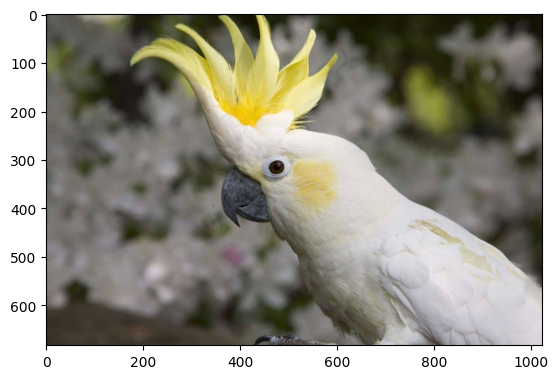

In [26]:
img = Image.open(os.path.join(folder_path, filenames[0]))
plt.imshow(img)


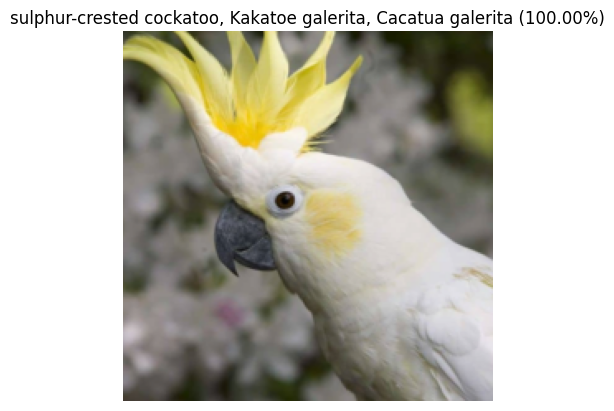

In [27]:
img_tensor = preprocess(img).unsqueeze(0).to(device)
output = model(img_tensor)
probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
label = labels[output.argmax().item()]
plt.imshow(tensor_to_pil(img_tensor))
plt.title(f"{label} ({probs*100:.2f}%)")
plt.axis('off')
plt.show()

In [28]:
# get the index of the target label from dictionary
target_label = "zebra"
target_index = list(labels.values()).index(target_label)
print(target_index)

340


In [29]:
def loss(output, mask, target_index, l2_weight):
    classification_loss = torch.nn.functional.cross_entropy(output, target_index)
    
    l2_loss = torch.pow(mask, 2).sum()
    
    total_loss =  classification_loss+(l2_weight * l2_loss)
    
    return total_loss, classification_loss, l2_loss

Step: 34  total loss: 6.6766    class loss: 1.4660     l2 loss: 10.4213   Predicted class index: 340

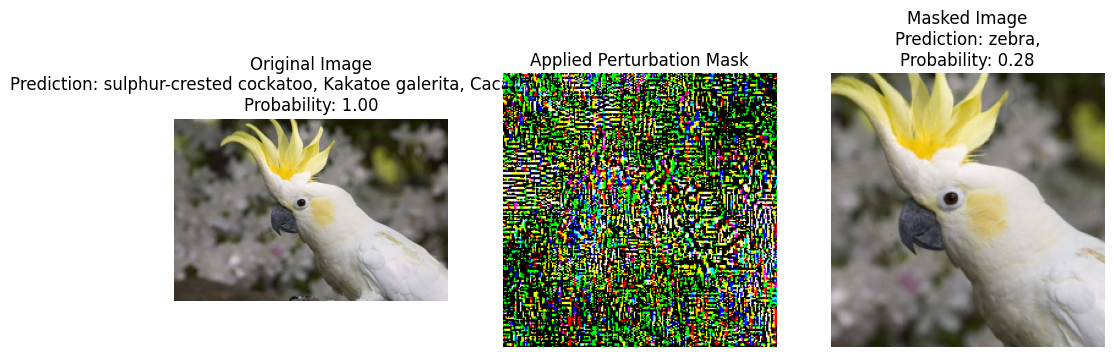

Step: 11  total loss: 4.1861    class loss: 1.8566     l2 loss: 4.6590   Predicted class index: 340

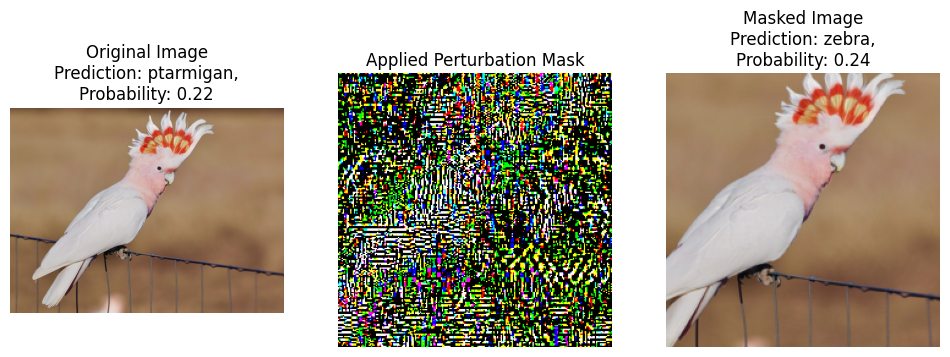

Step: 29  total loss: 7.1714    class loss: 1.6156     l2 loss: 11.1115   Predicted class index: 340

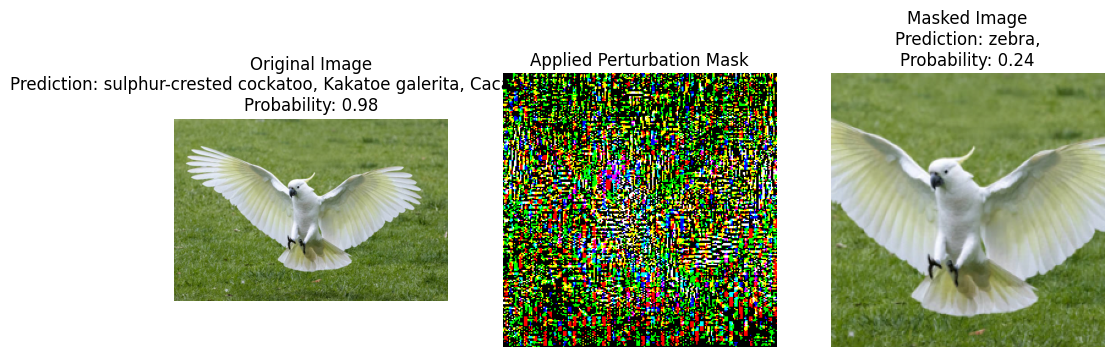

In [30]:
import sys  # Import sys to enable writing output to the terminal

# Loop over each image file in the sorted filenames list
for i, img in enumerate(filenames):
    # Open the image using PIL by constructing the full file path from the folder and image name
    img = Image.open(os.path.join(folder_path, img))
    
    # Preprocess the image:
    # - Convert it to a tensor with preprocess()
    # - Add a batch dimension using unsqueeze(0)
    # - Move the tensor to the specified device (CPU or GPU)
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    
    # Initialize a small random mask with the same shape as the image tensor.
    # Multiplying by 1e-4 ensures the perturbation starts very small.
    mask = torch.rand_like(img_tensor) * 1e-4
    
    # Convert the mask to a learnable parameter that tracks gradients.
    mask = torch.nn.Parameter(mask.to(device), requires_grad=True)
    # Set up the Adam optimizer to update the mask parameter only, with a learning rate of 1e-3.
    optimizer = torch.optim.Adam([mask], lr=1e-3)
    
    # Create a target tensor representing the desired class index and move it to the device.
    target = torch.tensor([target_index]).to(device)
    
    # Initialize a step counter for the optimization loop.
    step = 0
    while True:
        # Compute the model output by adding the mask to the original image tensor.
        output = model(img_tensor + mask)
        
        # Calculate the losses:
        # - total_loss: the overall loss combining classification and regularization (l2) terms
        # - classification_loss: measures the error in classification relative to the target
        # - l2_loss: penalizes large values in the mask (regularization), weighted by 0.5
        total_loss, classification_loss, l2_loss = loss(output, mask, target, 0.5)
        
        # Reset the gradients from the previous optimization step.
        optimizer.zero_grad()
        
        # Perform backpropagation to compute the gradients of total_loss with respect to the mask.
        total_loss.backward()
        
        # Update the mask using the optimizer.
        optimizer.step()
        
        # Write the current step, losses, and the predicted class index to stdout.
        sys.stdout.write(
            f"\rStep: {step}  total loss: {total_loss.item():4.4f}    "
            f"class loss: {classification_loss.item():4.4f}     "
            f"l2 loss: {l2_loss.item():4.4f}   Predicted class index: {output[0].argmax()}"
        )
        sys.stdout.flush()
        
        # Check if the current prediction matches the target class.
        if output[0].argmax().item() == target.item():
            # Create the masked image by adding the optimized mask to the original image tensor.
            masked_img = img_tensor + mask
            
            # Get model outputs for both the original and masked images.
            original = model(img_tensor)
            masked = model(masked_img)
            
            # Calculate probabilities for the most likely classes using softmax.
            probs = torch.softmax(original, dim=1)[0][original[0].argmax()].item()
            mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()
            
            # Retrieve human-readable labels for the predictions using the mapping dictionary.
            orig_label = labels[original[0].argmax().item()]
            masked_label = labels[masked[0].argmax().item()]
            
            # Set up a matplotlib figure to display the original image, the mask, and the masked image.
            plt.figure(figsize=(12,8))
            
            # Display the original image with its prediction and probability.
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f"Original Image\nPrediction: {orig_label},\nProbability: {probs:.2f}")
            plt.axis('off')
            
            # Convert the mask tensor to a PIL image for visualization.
            mask_pil = transforms.functional.to_pil_image(mask[0])
            # Display the applied perturbation mask.
            plt.subplot(1, 3, 2)
            plt.imshow(mask_pil)
            plt.title("Applied Perturbation Mask")
            plt.axis('off')
            
            # Display the masked image with its prediction and probability.
            plt.subplot(1, 3, 3)
            plt.imshow(tensor_to_pil(masked_img))
            plt.title(f"Masked Image\nPrediction: {masked_label},\nProbability: {mask_probs:.2f}")
            plt.axis('off')
            
            # Show the plot window.
            plt.show()
            
            # Break out of the optimization loop as the target prediction has been achieved.
            break
        
        # Increment the step counter for the next iteration.
        step += 1